# CSE6242 Project: Flight Delay Forecasting Using Machine Learning

In [144]:
# Importing necessary libraries for EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib
import pandas as pd

## Importing Data

In [147]:
# Load the dataset
file_path = 'flights_mod.csv'  # Ensure the file is in the same directory
df = pd.read_csv(file_path)

# Display the head of the dataframe to understand the structure
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Get an overview of data types and non-null counts
print(df.info())

# Basic statistics for numerical columns
print(df.describe())


      FL_DATE                AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
0  2019-01-09  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
1  2022-11-19   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2  2022-07-22  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
3  2023-03-06   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
4  2020-02-23       Spirit Air Lines       Spirit Air Lines: NK           NK   

   DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1     19790       1149    MSP      Minneapolis, MN  SEA   
2     19977        459    DEN           Denver, CO  MSP   
3     19790       2295    MSP      Minneapolis, MN  SFO   
4     20416        407    MCO          Orlando, FL  DFW   

               DEST_CITY  ...  DELAY_DUE_CARRIER  DELAY_DUE_WEATHER  \
0             Newark, NJ  ...                NaN                NaN   
1            Seattle, 

## Data Cleaning

The dataset we obtained from Kaggle includes a large number of flights, some of which were either diverted or cancelled. Including these flights in model training and predictions could negatively impact the model's accuracy, so we will exclude them from our dataset.

In [150]:
# Ensure no infinite valyes and no null values
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['ARR_DELAY'])

# Drop the rows where the flights got canceled
df_clean = df_clean[df_clean['CANCELLED'] == 0]

# Drop the rows where the flights got diverted
df_clean = df_clean[df_clean['DIVERTED'] == 0]




## Feature Engineering

We will apply date-time transformations, extract time-based features, and further refine these features into more granular details. Additionally, we will create interaction terms to capture potential meaningful relationships and use one-hot or label encoding as needed.

In [153]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Date-Time Transformation ####

# Convert FL_DATE to date format
df_clean['FL_DATE'] = pd.to_datetime(df_clean['FL_DATE'], format='%Y-%m-%d')

# Filter out COVID period 
start_date = '2020-02-01'
end_date = '2021-05-31'

# Filter the DataFrame to exclude rows within this date range
df_clean = df_clean[(df_clean['FL_DATE'] < start_date) | (df_clean['FL_DATE'] > end_date)]

# Extract day of the week
df_clean['day_of_week'] = df_clean['FL_DATE'].dt.dayofweek  # Monday=0, Sunday=6

# Extract month
df_clean['month'] = df_clean['FL_DATE'].dt.month

# Extract hour of the day from Scheduled departure time
df_clean['hour_of_day_Dep'] = df_clean['CRS_DEP_TIME'] // 100  # Assuming CRS_DEP_TIME is in HHMM format
df_clean['hour_of_day_Arr'] = df_clean['CRS_ARR_TIME'] // 100

df_transformed = df_clean

#### Break down the departure and arrival times into more granular features ####

# Define time slots based on departure hour
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply function to create time-of-day columns
df_transformed['DEP_TIME_OF_DAY'] = df_transformed['hour_of_day_Dep'].apply(categorize_time_of_day)
df_transformed['ARR_TIME_OF_DAY'] = df_transformed['hour_of_day_Arr'].apply(categorize_time_of_day)

#-----------------

# Create and fit encoders for each column
airline_encoder = LabelEncoder()
dest_encoder = LabelEncoder()
origin_encoder = LabelEncoder()

df_transformed['AIRLINE_CODE_Encoded'] = airline_encoder.fit_transform(df_transformed['AIRLINE_CODE'])
df_transformed['DEST_Encoded'] = dest_encoder.fit_transform(df_transformed['DEST'])
df_transformed['ORIGIN_Encoded'] = origin_encoder.fit_transform(df_transformed['ORIGIN'])


## To avoid issues when creating interaction terms later, we adjust the encoded values so they do not start from 0
# Shift the encoding to start from 1 instead of 0
df_transformed['AIRLINE_CODE_Encoded'] += 1
df_transformed['DEST_Encoded']+=1
df_transformed['ORIGIN_Encoded']+=1

# Create an interaction term 
df_transformed['elapsed_time_airlineCode_interaction'] = df_transformed['CRS_ELAPSED_TIME'] * df_transformed['AIRLINE_CODE_Encoded']
df_transformed['Origin_Dest_interaction'] = df_transformed['ORIGIN_Encoded'] * df_transformed['DEST_Encoded']
df_transformed['AirlineCode_FlightNumber_Origin_Dest_interaction'] = df_transformed['AIRLINE_CODE_Encoded'] * df_transformed['FL_NUMBER']*df_transformed['ORIGIN_Encoded'] * df_transformed['DEST_Encoded']


#-----------------

#### Drop columns that reveal outcome and redundant columns
df_transformed_1 = df_transformed.drop(["AIRLINE_DOT", "DOT_CODE","AIRLINE", "CANCELLATION_CODE",
                                "DIVERTED", "CANCELLED", 
                                "DEP_TIME", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON",
                                "TAXI_IN", "ARR_TIME", 
                                "ELAPSED_TIME", "AIR_TIME", "DELAY_DUE_CARRIER", 
                                "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY",
                                "DELAY_DUE_LATE_AIRCRAFT","ORIGIN_CITY", "DEST_CITY",
                                "hour_of_day_Dep","hour_of_day_Arr", "AIRLINE_CODE","DEST","ORIGIN"], axis=1)

# Apply categorization to flight duration
def categorize_elapsed_time(mins):
    if mins <= 180:
        return 'Short'
    elif 180 < mins <= 360:
        return 'Medium'
    elif 360 < mins <= 720:
        return 'Long'
    else:
        return 'Ultra-long'

# Apply function to create time-of-day columns
df_transformed_1['flight_duration'] = df_transformed_1['CRS_ELAPSED_TIME'].apply(categorize_elapsed_time)


# Interaction between flight duration and airline_code
flight_duration_encoder = LabelEncoder()
df_transformed_1['flight_duration_Encoded'] = flight_duration_encoder.fit_transform(df_transformed_1['flight_duration'])
df_transformed_1['flight_duration_Encoded']+=1
df_transformed_1['flight_duration_AirlineCode_interaction'] = df_transformed_1['flight_duration_Encoded'] * df_transformed_1['AIRLINE_CODE_Encoded']
df_transformed_1 = df_transformed_1.drop(["CRS_ELAPSED_TIME", "CRS_ARR_TIME", "CRS_DEP_TIME","DISTANCE",'elapsed_time_airlineCode_interaction'], axis=1)
#print(df_transformed_1.columns)


# One-hot encode specified columns
df_transformed_encoded = pd.get_dummies(df_transformed_1[['day_of_week', 'month','DEP_TIME_OF_DAY', 'ARR_TIME_OF_DAY', 'ORIGIN_COUNTRY',
                                                        'ORIGIN_AIRPORT_SIZE','DEST_COUNTRY','DEST_AIRPORT_SIZE','FL_Type','flight_duration']], drop_first=True)
#print(df_transformed_encoded.columns)
df_transformed_to_concat = df_transformed_1[[ 'ARR_DELAY', 'DEP_DELAY',
                                              'AIRLINE_CODE_Encoded', 'DEST_Encoded', 'ORIGIN_Encoded', 
                                              'AirlineCode_FlightNumber_Origin_Dest_interaction', 'flight_duration_Encoded', 
                                              'flight_duration_AirlineCode_interaction','FL_NUMBER','Origin_Dest_interaction','FL_DATE']]

#print(df_transformed_to_concat.columns)

# Concatenate the non-encoded columns back 
df_transformed_final = pd.concat([df_transformed_encoded, df_transformed_to_concat], axis=1)

# Save each encoder using joblib
joblib.dump(airline_encoder, 'airline_encoder.pkl')
joblib.dump(dest_encoder, 'dest_encoder.pkl')
joblib.dump(origin_encoder, 'origin_encoder.pkl')
joblib.dump(flight_duration_encoder, 'flight_duration_encoder.pkl')

print(df_transformed_final.columns)
df_transformed_final.info()
df_transformed_final['AIRLINE_CODE_Encoded'].head()

Index(['day_of_week', 'month', 'DEP_TIME_OF_DAY_Evening',
       'DEP_TIME_OF_DAY_Morning', 'DEP_TIME_OF_DAY_Night',
       'ARR_TIME_OF_DAY_Evening', 'ARR_TIME_OF_DAY_Morning',
       'ARR_TIME_OF_DAY_Night', 'ORIGIN_COUNTRY_GU', 'ORIGIN_COUNTRY_MP',
       'ORIGIN_COUNTRY_PR', 'ORIGIN_COUNTRY_US', 'ORIGIN_COUNTRY_VI',
       'ORIGIN_AIRPORT_SIZE_medium_airport',
       'ORIGIN_AIRPORT_SIZE_small_airport', 'DEST_COUNTRY_GU',
       'DEST_COUNTRY_MP', 'DEST_COUNTRY_PR', 'DEST_COUNTRY_US',
       'DEST_COUNTRY_VI', 'DEST_AIRPORT_SIZE_medium_airport',
       'DEST_AIRPORT_SIZE_small_airport', 'FL_Type_International',
       'flight_duration_Medium', 'flight_duration_Short', 'ARR_DELAY',
       'DEP_DELAY', 'AIRLINE_CODE_Encoded', 'DEST_Encoded', 'ORIGIN_Encoded',
       'AirlineCode_FlightNumber_Origin_Dest_interaction',
       'flight_duration_Encoded', 'flight_duration_AirlineCode_interaction',
       'FL_NUMBER', 'Origin_Dest_interaction', 'FL_DATE'],
      dtype='object')
<class 'pan

0    15
1     5
2    15
3     5
5    16
Name: AIRLINE_CODE_Encoded, dtype: int64

### Create Prev_Delay Column to provide historical delay patterns

We will create a 'Prev_Delay_Column' using only the training dataset. This will enable the model to capture previous delay data based on ORIGIN, DEST, AIRLINE_CODE, and FL_DATE. By including this column, we provide the model with historical delay patterns, which can help improve its predictive accuracy, as delays on similar routes or with the same airline may repeat. Additionally, this approach ensures there is no data leakage by using only the training dataset, maintaining the integrity of the model

In [396]:
import pickle

# save airport size as dict 
origin_mapping = df_transformed_1[['ORIGIN_Encoded','ORIGIN_AIRPORT_SIZE']].drop_duplicates()
dest_mapping = df_transformed_1[['DEST_Encoded','DEST_AIRPORT_SIZE']].drop_duplicates()

origin_mapping_dicts = dict(zip(origin_mapping['ORIGIN_Encoded'],origin_mapping['ORIGIN_AIRPORT_SIZE']))
dest_mapping_dicts = dict(zip(dest_mapping['DEST_Encoded'],dest_mapping['DEST_AIRPORT_SIZE']))

with open('origin_dicts.pkl','wb') as f: #ensures that the file is properly opened and closed after saving the dictionary
    pickle.dump(origin_mapping_dicts,f)
    
with open('dest_dicts.pkl','wb') as f:
    pickle.dump(dest_mapping_dicts,f)

# save country as dict 
origin_country_mapping = df_transformed_1[['ORIGIN_Encoded','ORIGIN_COUNTRY']].drop_duplicates()
dest_country_mapping = df_transformed_1[['DEST_Encoded','DEST_COUNTRY']].drop_duplicates()

origin_country_dicts = dict(zip(origin_country_mapping['ORIGIN_Encoded'],origin_country_mapping['ORIGIN_COUNTRY']))
dest_country_dicts = dict(zip(dest_country_mapping['DEST_Encoded'],dest_country_mapping['DEST_COUNTRY']))

with open('origin_country_dicts.pkl','wb') as f: #ensures that the file is properly opened and closed after saving the dictionary
    pickle.dump(origin_country_dicts,f)
    
with open('dest_country_dicts.pkl','wb') as f:
    pickle.dump(dest_country_dicts,f)

In [158]:

# df_transformed_final['Delay_Category'] = df_transformed_final['ARR_DELAY'].apply(lambda x: 1 if x > 15 else 0)

# # Count the number of occurrences in each category
# category_counts = df_transformed_final['Delay_Category'].value_counts()
# print("Counts of each delay category:")
# print(category_counts)

df_transformed_final['AIRLINE_CODE_Encoded'] = df_transformed_final['AIRLINE_CODE_Encoded'].astype('category')
df_transformed_final['ORIGIN_Encoded'] = df_transformed_final['ORIGIN_Encoded'].astype('category')
df_transformed_final['DEST_Encoded'] = df_transformed_final['DEST_Encoded'].astype('category')


# Split the data into training and test sets
train_data, test_data = train_test_split(df_transformed_final, test_size=0.2, random_state=42)

# Sort by airline, flight number, origin, destination, and flight date to ensure correct ordering
train_data = train_data.sort_values(by=['AIRLINE_CODE_Encoded', 'FL_NUMBER', 'ORIGIN_Encoded', 'DEST_Encoded', 'FL_DATE'])

# Create the previous departure delay column
train_data['PREV_DEP_DELAY'] = train_data.groupby(['AIRLINE_CODE_Encoded', 'FL_NUMBER', 'ORIGIN_Encoded', 'DEST_Encoded'])['DEP_DELAY'].shift(1)

# Fill missing values (for first flight, as there's no previous flight to track)
train_data['PREV_DEP_DELAY'].fillna(0, inplace=True)

# Ensure correct data type
train_data['PREV_DEP_DELAY'] = train_data['PREV_DEP_DELAY'].astype(float)

prev_delay_train = train_data[['AIRLINE_CODE_Encoded', 'FL_NUMBER', 'ORIGIN_Encoded', 'DEST_Encoded', 'PREV_DEP_DELAY']]

test_data['PREV_DEP_DELAY'] = test_data.apply(
    lambda row: prev_delay_train[
        (prev_delay_train['AIRLINE_CODE_Encoded'] == row['AIRLINE_CODE_Encoded']) &
        (prev_delay_train['FL_NUMBER'] == row['FL_NUMBER']) &
        (prev_delay_train['ORIGIN_Encoded'] == row['ORIGIN_Encoded']) &
        (prev_delay_train['DEST_Encoded'] == row['DEST_Encoded'])
    ]['PREV_DEP_DELAY'].values[0] if not prev_delay_train[
        (prev_delay_train['AIRLINE_CODE_Encoded'] == row['AIRLINE_CODE_Encoded']) &
        (prev_delay_train['FL_NUMBER'] == row['FL_NUMBER']) &
        (prev_delay_train['ORIGIN_Encoded'] == row['ORIGIN_Encoded']) &
        (prev_delay_train['DEST_Encoded'] == row['DEST_Encoded'])
    ].empty else 0,
    axis=1
)
test_data['PREV_DEP_DELAY'] = test_data['PREV_DEP_DELAY'].astype(float)
 

### Incorporating network centrality into the model

In [340]:
import networkx as nx


# Cast back to int
train_data['AIRLINE_CODE_Encoded'] = train_data['AIRLINE_CODE_Encoded'].astype(int)
train_data['DEST_Encoded'] = train_data['DEST_Encoded'].astype(int)
train_data['ORIGIN_Encoded'] = train_data['ORIGIN_Encoded'].astype(int)

test_data['AIRLINE_CODE_Encoded'] = test_data['AIRLINE_CODE_Encoded'].astype(int)
test_data['DEST_Encoded'] = test_data['DEST_Encoded'].astype(int)
test_data['ORIGIN_Encoded'] = test_data['ORIGIN_Encoded'].astype(int)


# Create separate directed graphs for origins and destinations
G_origin = nx.DiGraph()
G_dest = nx.DiGraph()

# Add edges to the graphs
for index, row in X_train.iterrows():
    G_origin.add_edge(row['ORIGIN_Encoded'], row['DEST_Encoded'])  # Graph for origin
    G_dest.add_edge(row['DEST_Encoded'], row['ORIGIN_Encoded'])  # Graph for destination

# Compute centrality values for the separate graphs
degree_centrality_origin = nx.degree_centrality(G_origin)
betweenness_centrality_origin = nx.betweenness_centrality(G_origin, normalized=True)

degree_centrality_dest = nx.degree_centrality(G_dest)
betweenness_centrality_dest = nx.betweenness_centrality(G_dest, normalized=True)

# Add centrality values to the training set
train_data['origin_degree_centrality'] = train_data['ORIGIN_Encoded'].map(degree_centrality_origin)
train_data['dest_degree_centrality'] = train_data['DEST_Encoded'].map(degree_centrality_dest)

train_data['origin_betweenness_centrality'] = train_data['ORIGIN_Encoded'].map(betweenness_centrality_origin)
train_data['dest_betweenness_centrality'] = train_data['DEST_Encoded'].map(betweenness_centrality_dest)

# Use the training set's centrality values to map to the test set (no recalculation for the test set)
test_data['origin_degree_centrality'] = test_data['ORIGIN_Encoded'].map(degree_centrality_origin)
test_data['dest_degree_centrality'] = test_data['DEST_Encoded'].map(degree_centrality_dest)

test_data['origin_betweenness_centrality'] = test_data['ORIGIN_Encoded'].map(betweenness_centrality_origin)
test_data['dest_betweenness_centrality'] = test_data['DEST_Encoded'].map(betweenness_centrality_dest)


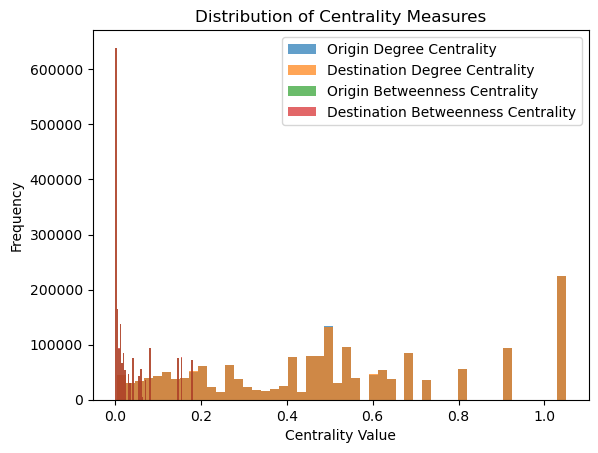

In [330]:
# Check the distribution of centrality measures
import matplotlib.pyplot as plt

# Plot the degree centrality distribution
plt.hist(centrality_data['origin_degree_centrality'], bins=50, alpha=0.7, label='Origin Degree Centrality')
plt.hist(centrality_data['dest_degree_centrality'], bins=50, alpha=0.7, label='Destination Degree Centrality')
plt.hist(centrality_data['origin_betweenness_centrality'], bins=50, alpha=0.7, label='Origin Betweenness Centrality')
plt.hist(centrality_data['dest_betweenness_centrality'], bins=50, alpha=0.7, label='Destination Betweenness Centrality')

plt.legend(loc='upper right')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')
plt.title('Distribution of Centrality Measures')
plt.show()


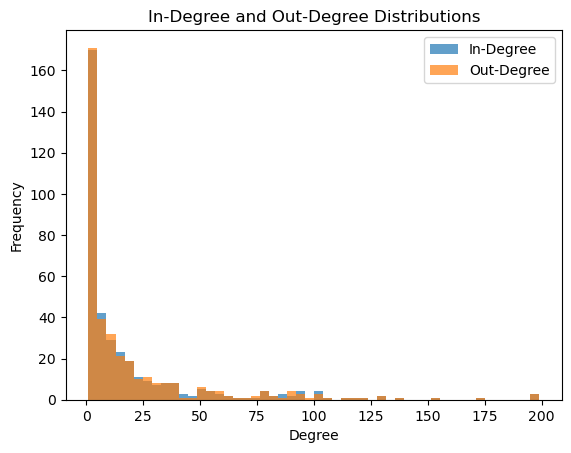

In [342]:
# Compute in-degree and out-degree distributions
in_degrees = [G_train.in_degree(n) for n in G_train.nodes()]
out_degrees = [G_train.out_degree(n) for n in G_train.nodes()]

# Plot in-degree and out-degree distributions
plt.hist(in_degrees, bins=50, alpha=0.7, label='In-Degree')
plt.hist(out_degrees, bins=50, alpha=0.7, label='Out-Degree')
plt.legend(loc='upper right')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('In-Degree and Out-Degree Distributions')
plt.show()


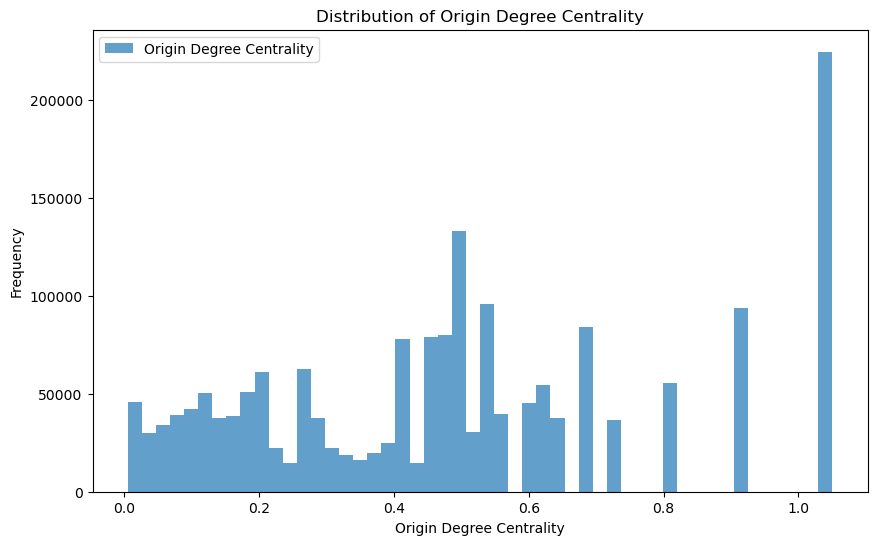

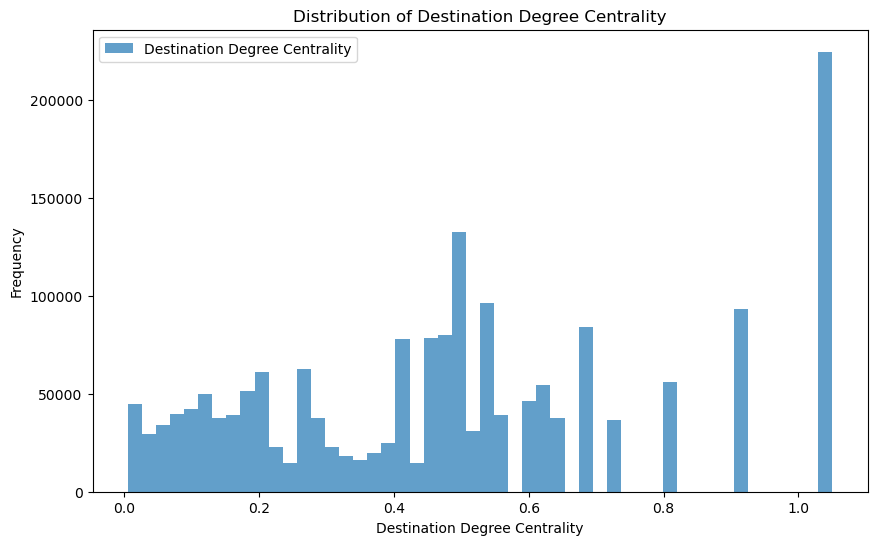

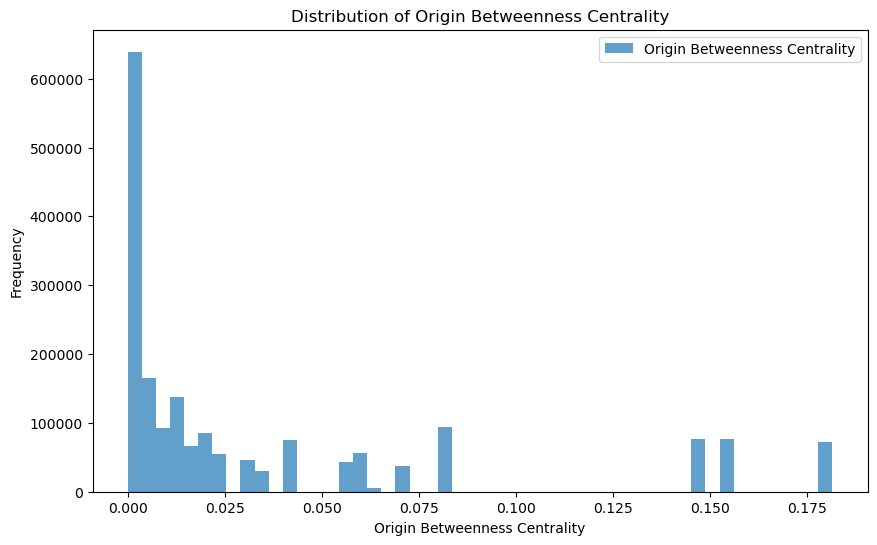

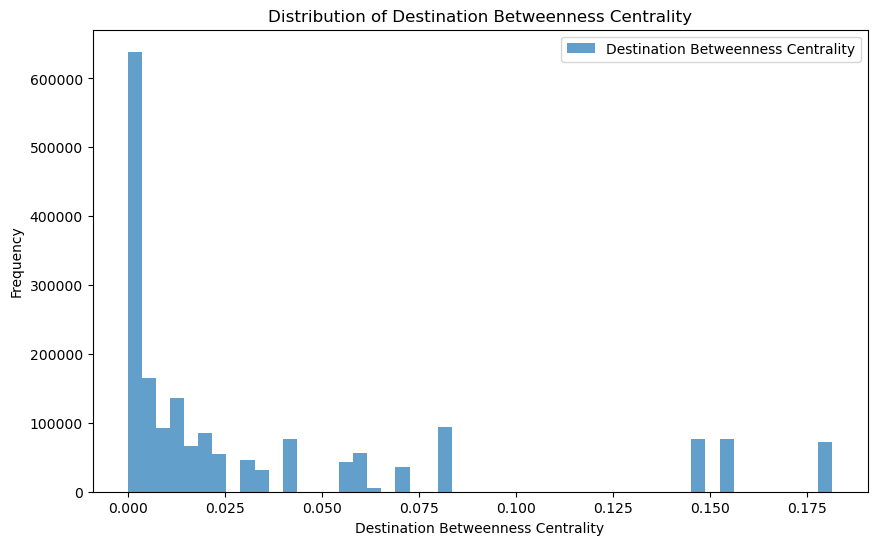

In [343]:
# Plot each centrality measure separately
plt.figure(figsize=(10, 6))
plt.hist(centrality_data['origin_degree_centrality'], bins=50, alpha=0.7, label='Origin Degree Centrality')
plt.xlabel('Origin Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Origin Degree Centrality')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(centrality_data['dest_degree_centrality'], bins=50, alpha=0.7, label='Destination Degree Centrality')
plt.xlabel('Destination Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Destination Degree Centrality')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(centrality_data['origin_betweenness_centrality'], bins=50, alpha=0.7, label='Origin Betweenness Centrality')
plt.xlabel('Origin Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Origin Betweenness Centrality')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(centrality_data['dest_betweenness_centrality'], bins=50, alpha=0.7, label='Destination Betweenness Centrality')
plt.xlabel('Destination Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Destination Betweenness Centrality')
plt.legend()
plt.show()


Since the in-degree and out-degree distributions are almost identical, this in turns causes the origin and destination centrality values to be very similar. In order to reduce feature redundancy, Origin's set of centrality will be dropped.

In [351]:
# Save only the centrality columns to a separate file
centrality_data = train_data[['ORIGIN_Encoded', 'DEST_Encoded',
                             'dest_degree_centrality', 'dest_betweenness_centrality']]
centrality_data.to_pickle('centrality_data.pkl')
#print(centrality_data.head())

# # Filter for rows where ORIGIN_Encoded is 10 and select only the origin_betweenness_centrality column
# dest_betweenness_values = centrality_data[centrality_data['DEST_Encoded'] == 211]['dest_betweenness_centrality']

# # Display the filtered values
# print(dest_betweenness_values.head())

# Save the results to a CSV file
centrality_data.to_csv('centrality_data.csv', index=False)

print("CSV file 'centrality_data.csv' has been created.")

train_data= train_data.drop(['origin_degree_centrality','origin_betweenness_centrality'],axis=1)
test_data= test_data.drop(['origin_degree_centrality','origin_betweenness_centrality'],axis=1)
train_data.columns



CSV file 'centrality_data.csv' has been created.


Index(['day_of_week', 'month', 'DEP_TIME_OF_DAY_Evening',
       'DEP_TIME_OF_DAY_Morning', 'DEP_TIME_OF_DAY_Night',
       'ARR_TIME_OF_DAY_Evening', 'ARR_TIME_OF_DAY_Morning',
       'ARR_TIME_OF_DAY_Night', 'ORIGIN_COUNTRY_GU', 'ORIGIN_COUNTRY_MP',
       'ORIGIN_COUNTRY_PR', 'ORIGIN_COUNTRY_US', 'ORIGIN_COUNTRY_VI',
       'ORIGIN_AIRPORT_SIZE_medium_airport',
       'ORIGIN_AIRPORT_SIZE_small_airport', 'DEST_COUNTRY_GU',
       'DEST_COUNTRY_MP', 'DEST_COUNTRY_PR', 'DEST_COUNTRY_US',
       'DEST_COUNTRY_VI', 'DEST_AIRPORT_SIZE_medium_airport',
       'DEST_AIRPORT_SIZE_small_airport', 'FL_Type_International',
       'flight_duration_Medium', 'flight_duration_Short', 'ARR_DELAY',
       'DEP_DELAY', 'AIRLINE_CODE_Encoded', 'DEST_Encoded', 'ORIGIN_Encoded',
       'AirlineCode_FlightNumber_Origin_Dest_interaction',
       'flight_duration_Encoded', 'flight_duration_AirlineCode_interaction',
       'FL_NUMBER', 'Origin_Dest_interaction', 'FL_DATE', 'PREV_DEP_DELAY',
       'dest_deg

## Model Training

In [353]:
# Model 1: Delay is defined as arrival delay greater than 15 minutes
# Cast back to int
# X_train = X_train.astype({'AIRLINE_CODE_Encoded': 'int', 'ORIGIN_Encoded': 'int', 'DEST_Encoded': 'int'})
# X_test = X_test.astype({'AIRLINE_CODE_Encoded': 'int', 'ORIGIN_Encoded': 'int', 'DEST_Encoded': 'int'})

def define_delay_category(df, delay_threshold=15):
    df['Delay_Category'] = df['ARR_DELAY'].apply(lambda x: 1 if x > delay_threshold else 0)

# Call this function to define Delay_Category after the preprocessing
define_delay_category(train_data, delay_threshold=15)  # Define with delay > 15 mins
define_delay_category(test_data, delay_threshold=15)

# Check the counts of each delay category
category_counts = train_data['Delay_Category'].value_counts()
print("Counts of each delay category:")
print(category_counts)

# Define the feature set (X) and target (y)
X_train = train_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_train = train_data['Delay_Category']
X_test = test_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_test = test_data['Delay_Category']

# Cast back to int
X_train['AIRLINE_CODE_Encoded'] = X_train['AIRLINE_CODE_Encoded'].astype(int)
X_train['DEST_Encoded'] = X_train['DEST_Encoded'].astype(int)
X_train['ORIGIN_Encoded'] = X_train['ORIGIN_Encoded'].astype(int)

X_test['AIRLINE_CODE_Encoded'] = X_test['AIRLINE_CODE_Encoded'].astype(int)
X_test['DEST_Encoded'] = X_test['DEST_Encoded'].astype(int)
X_test['ORIGIN_Encoded'] = X_test['ORIGIN_Encoded'].astype(int)

print(X_train.dtypes)


Counts of each delay category:
Delay_Category
0    1487428
1     366173
Name: count, dtype: int64
day_of_week                                           int32
month                                                 int32
DEP_TIME_OF_DAY_Evening                                bool
DEP_TIME_OF_DAY_Morning                                bool
DEP_TIME_OF_DAY_Night                                  bool
ARR_TIME_OF_DAY_Evening                                bool
ARR_TIME_OF_DAY_Morning                                bool
ARR_TIME_OF_DAY_Night                                  bool
ORIGIN_COUNTRY_GU                                      bool
ORIGIN_COUNTRY_MP                                      bool
ORIGIN_COUNTRY_PR                                      bool
ORIGIN_COUNTRY_US                                      bool
ORIGIN_COUNTRY_VI                                      bool
ORIGIN_AIRPORT_SIZE_medium_airport                     bool
ORIGIN_AIRPORT_SIZE_small_airport                      bool
DE

In [355]:
# Check for missing values in each column
missing_values = X_train.isnull().sum()

# Filter columns that have missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Print the columns with missing values and the number of missing values
print(columns_with_missing_values)

# Check for empty strings or other missing representations
missing_rep = (X_train == '').sum()
print("Empty strings or placeholders in each column:", missing_rep)

# Check again for any NaNs using a thorough inspection
missing_values = X_train.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

# Print columns with NaNs if they exist
print("Columns with missing values and their counts:")
print(columns_with_missing_values)

print(X_train.dtypes)


Series([], dtype: int64)
Empty strings or placeholders in each column: day_of_week                                         0
month                                               0
DEP_TIME_OF_DAY_Evening                             0
DEP_TIME_OF_DAY_Morning                             0
DEP_TIME_OF_DAY_Night                               0
ARR_TIME_OF_DAY_Evening                             0
ARR_TIME_OF_DAY_Morning                             0
ARR_TIME_OF_DAY_Night                               0
ORIGIN_COUNTRY_GU                                   0
ORIGIN_COUNTRY_MP                                   0
ORIGIN_COUNTRY_PR                                   0
ORIGIN_COUNTRY_US                                   0
ORIGIN_COUNTRY_VI                                   0
ORIGIN_AIRPORT_SIZE_medium_airport                  0
ORIGIN_AIRPORT_SIZE_small_airport                   0
DEST_COUNTRY_GU                                     0
DEST_COUNTRY_MP                                     0
DEST_COUNTR

### Logistic Regression

In [357]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize Logistic Regression model
lr_model = LogisticRegression(
    solver='liblinear',  # Use liblinear solver for smaller datasets
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Train the model
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = lr_model.predict(X_test)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix:')
print(conf_matrix_lr)

print('Classification Report:')
print(classification_report(y_test, y_pred_lr))


#----------------
import numpy as np

# Predict probabilities for class 1
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)

    accuracy_lr = accuracy_score(y_test, y_pred_threshold)
    print(f'Threshold: {threshold:.1f}, Accuracy: {accuracy_lr * 100:.2f}%')

    # Confusion Matrix and Classification Report
    conf_matrix_lr = confusion_matrix(y_test, y_pred_threshold)
    print('Confusion Matrix:')
    print(conf_matrix_lr)

    print('Classification Report:')
    print(classification_report(y_test, y_pred_threshold))


Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401

Threshold: 0.1, Accuracy: 19.79%
Confusion Matrix:
[[     0 371710]
 [     0  91691]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anacond

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    371710
           1       0.20      1.00      0.33     91691

    accuracy                           0.20    463401
   macro avg       0.10      0.50      0.17    463401
weighted avg       0.04      0.20      0.07    463401

Threshold: 0.2, Accuracy: 19.79%
Confusion Matrix:
[[     0 371710]
 [     0  91691]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    371710
           1       0.20      1.00      0.33     91691

    accuracy                           0.20    463401
   macro avg       0.10      0.50      0.17    463401
weighted avg       0.04      0.20      0.07    463401

Threshold: 0.3, Accuracy: 19.79%
Confusion Matrix:
[[     0 371710]
 [     0  91691]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anacond

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    371710
           1       0.20      1.00      0.33     91691

    accuracy                           0.20    463401
   macro avg       0.10      0.50      0.17    463401
weighted avg       0.04      0.20      0.07    463401

Threshold: 0.4, Accuracy: 19.79%
Confusion Matrix:
[[     0 371710]
 [     0  91691]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    371710
           1       0.20      1.00      0.33     91691

    accuracy                           0.20    463401
   macro avg       0.10      0.50      0.17    463401
weighted avg       0.04      0.20      0.07    463401

Threshold: 0.5, Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anacond

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401

Threshold: 0.6, Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401

Threshold: 0.7, Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anacond

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401

Threshold: 0.8, Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401

Threshold: 0.9, Accuracy: 80.21%
Confusion Matrix:
[[371710      0]
 [ 91691      0]]
Classification Report:


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89    371710
           1       0.00      0.00      0.00     91691

    accuracy                           0.80    463401
   macro avg       0.40      0.50      0.45    463401
weighted avg       0.64      0.80      0.71    463401



/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [360]:
# Random Forest

# Initialize Random Forest Classifier
# rf_model = RandomForestClassifier(n_estimators=100,
#                                   class_weight='balanced',
#                                   random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=100,
    #max_depth=8,                # Further reduce depth
    #min_samples_split=20,        # Ensure nodes have more samples before splitting
    #min_samples_leaf=6,          # Prevent overfitting on small sample sizes
    class_weight='balanced',     # Use class balancing
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 78.59%
Confusion Matrix:
[[354945  16765]
 [ 82427   9264]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88    371710
           1       0.36      0.10      0.16     91691

    accuracy                           0.79    463401
   macro avg       0.58      0.53      0.52    463401
weighted avg       0.72      0.79      0.73    463401



In [383]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],              # Number of trees in the forest
    'max_depth': [ 20, 30],              # Maximum depth of the tree
    'min_samples_split': [ 5, 10],              # Minimum samples required to split an internal node
    'min_samples_leaf': [ 2, 4],                # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],    # Number of features to consider when looking for the best split
    #'bootstrap': [True, False],                   # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3,  # 3-fold cross-validation
                           #n_jobs=-1,  # Use all cores
                           verbose=2,  # Show progress
                           scoring='accuracy')  # You can change this to 'f1', 'precision', or 'recall'

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}')

# Predict with the best model
y_pred_rf = grid_search.best_estimator_.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:')
print(conf_matrix_rf)

print('Classification Report:')
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.5s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.3s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  25.8s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  56.7s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  56.0s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  55.4s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  30.1s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  28.9s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  29.2s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  59.2s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  57.9s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  31.4s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  30.1s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  29.8s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=18.1min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=17.5min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  51.6s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  29.2s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  28.9s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  28.9s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  49.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  47.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  46.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  52.9s
[CV] END max_depth=20, max_features=sq

/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  56.1s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  55.4s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  54.7s


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.9min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.9min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.9min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.0min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.1min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.4min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.4min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.3min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.2min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.2min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.2min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.5min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.4min


/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.3min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.5min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.4min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, max_features=sq

/Users/kikiang/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.84
Accuracy: 90.84%
Confusion Matrix:
[[418115  13519]
 [ 28931   2836]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    431634
           1       0.17      0.09      0.12     31767

    accuracy                           0.91    463401
   macro avg       0.55      0.53      0.53    463401
weighted avg       0.88      0.91      0.89    463401



In [362]:
# Create SMOTE object with a suitable sampling ratio
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Adjust sampling ratio to fit your data

# Create a pipeline that applies SMOTE and then trains the model
pipeline = Pipeline([
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # You could also try custom weights like {0: 1, 1: 3}
        n_jobs=-1,                # Use all available cores
        random_state=42
    ))
])

# Train the pipeline model
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 77.40%
Confusion Matrix:
[[345672  26038]
 [ 78698  12993]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87    371710
           1       0.33      0.14      0.20     91691

    accuracy                           0.77    463401
   macro avg       0.57      0.54      0.53    463401
weighted avg       0.72      0.77      0.74    463401



In [363]:
from imblearn.over_sampling import ADASYN

pipeline = Pipeline([
    ('adasyn', ADASYN(sampling_strategy=0.8, random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])
# Train the pipeline model
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 77.45%
Confusion Matrix:
[[346031  25679]
 [ 78813  12878]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87    371710
           1       0.33      0.14      0.20     91691

    accuracy                           0.77    463401
   macro avg       0.57      0.54      0.53    463401
weighted avg       0.72      0.77      0.74    463401



In [364]:
xgb_model = XGBClassifier(
    scale_pos_weight=3,        # Adjusted for better balance
    max_depth=6,               # Control model complexity
    learning_rate=0.1,         # Lower learning rate for better convergence
    n_estimators=200,          # More trees can improve performance
    min_child_weight=5,        # Minimum sum of instance weight needed in a child
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))

joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(X_train.columns, 'X_train_columns.pkl')  # Save the column names




Accuracy: 72.23%
Confusion Matrix:
[[296029  75681]
 [ 53004  38687]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82    371710
           1       0.34      0.42      0.38     91691

    accuracy                           0.72    463401
   macro avg       0.59      0.61      0.60    463401
weighted avg       0.75      0.72      0.73    463401



['X_train_columns.pkl']

#### Since the goal of the project is to minimize disruption for passengers and airline operations by identifying delays as early as possible, prioritizing recall for class 1(delayed flights) is essential. While the random forest model achieved the highest overall accuracy, XGBoost outperformed all other models in detecting delayed flights, making it the chosen model for deployment. The team will train XGBoost on the dataset four times, each with a different delay threshold. This approach will help estimate the expected delay duration for each flight.

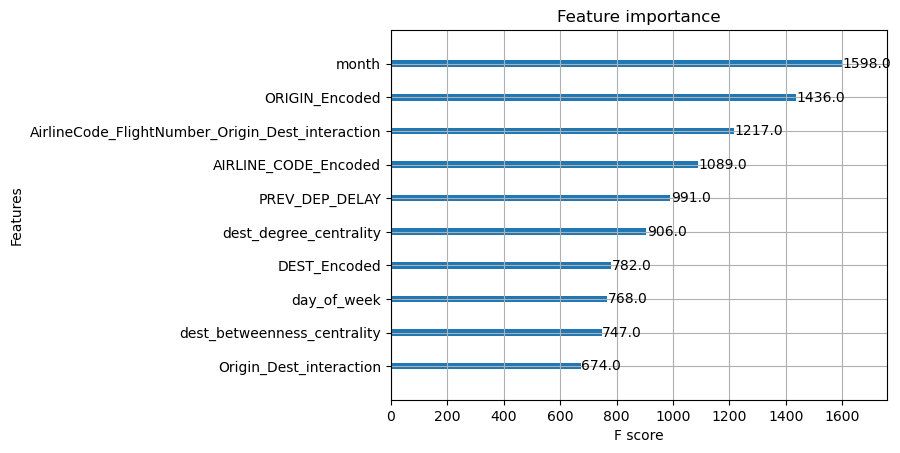

In [366]:
##Visualize XGBoost most important variables

import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance for XGBoost
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()


In [367]:
# Model 2: Delay is defined as arrival delay greater than 30 minutes

def define_delay_category(df, delay_threshold=30):
    df['Delay_Category'] = df['ARR_DELAY'].apply(lambda x: 1 if x > delay_threshold else 0)

# Call this function to define Delay_Category after the preprocessing
define_delay_category(train_data, delay_threshold=30)  # Define with delay > 30 mins
define_delay_category(test_data, delay_threshold=30)

# Check the counts of each delay category
category_counts = train_data['Delay_Category'].value_counts()
print("Counts of each delay category:")
print(category_counts)

# Define the feature set (X) and target (y)
X_train = train_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_train = train_data['Delay_Category']
X_test = test_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_test = test_data['Delay_Category']

# Cast back to int
X_train['AIRLINE_CODE_Encoded'] = X_train['AIRLINE_CODE_Encoded'].astype(int)
X_train['DEST_Encoded'] = X_train['DEST_Encoded'].astype(int)
X_train['ORIGIN_Encoded'] = X_train['ORIGIN_Encoded'].astype(int)

X_test['AIRLINE_CODE_Encoded'] = X_test['AIRLINE_CODE_Encoded'].astype(int)
X_test['DEST_Encoded'] = X_test['DEST_Encoded'].astype(int)
X_test['ORIGIN_Encoded'] = X_test['ORIGIN_Encoded'].astype(int)

#print(X_train.dtypes)


xgb_model_2 = XGBClassifier(
    scale_pos_weight=4,        # Adjusted for better balance
    max_depth=6,               # Control model complexity
    learning_rate=0.1,         # Lower learning rate for better convergence
    n_estimators=200,          # More trees can improve performance
    min_child_weight=5,        # Minimum sum of instance weight needed in a child
    random_state=42
)
xgb_model_2.fit(X_train, y_train)
y_pred = xgb_model_2.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))

joblib.dump(xgb_model_2, 'xgb_model_2.pkl')
#joblib.dump(X_train.columns, 'X_train_columns.pkl')  # Save the column names



Counts of each delay category:
Delay_Category
0    1615809
1     237792
Name: count, dtype: int64
Accuracy: 80.37%
Confusion Matrix:
[[353533  50456]
 [ 40512  18900]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89    403989
           1       0.27      0.32      0.29     59412

    accuracy                           0.80    463401
   macro avg       0.58      0.60      0.59    463401
weighted avg       0.82      0.80      0.81    463401



['xgb_model_2.pkl']

In [368]:
# Model 3: Delay is defined as arrival delay greater than 45 minutes

def define_delay_category(df, delay_threshold=45):
    df['Delay_Category'] = df['ARR_DELAY'].apply(lambda x: 1 if x > delay_threshold else 0)

# Call this function to define Delay_Category after the preprocessing
define_delay_category(train_data, delay_threshold=45)  # Define with delay > 45 mins
define_delay_category(test_data, delay_threshold=45)

# Check the counts of each delay category
category_counts = train_data['Delay_Category'].value_counts()
print("Counts of each delay category:")
print(category_counts)

# Define the feature set (X) and target (y)
X_train = train_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_train = train_data['Delay_Category']
X_test = test_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_test = test_data['Delay_Category']

# Cast back to int
X_train['AIRLINE_CODE_Encoded'] = X_train['AIRLINE_CODE_Encoded'].astype(int)
X_train['DEST_Encoded'] = X_train['DEST_Encoded'].astype(int)
X_train['ORIGIN_Encoded'] = X_train['ORIGIN_Encoded'].astype(int)

X_test['AIRLINE_CODE_Encoded'] = X_test['AIRLINE_CODE_Encoded'].astype(int)
X_test['DEST_Encoded'] = X_test['DEST_Encoded'].astype(int)
X_test['ORIGIN_Encoded'] = X_test['ORIGIN_Encoded'].astype(int)

#print(X_train.dtypes)

xgb_model_3 = XGBClassifier(
    scale_pos_weight=5,        # Adjusted for better balance
    max_depth=6,               # Control model complexity
    learning_rate=0.1,         # Lower learning rate for better convergence
    n_estimators=200,          # More trees can improve performance
    min_child_weight=5,        # Minimum sum of instance weight needed in a child
    random_state=42
)
xgb_model_3.fit(X_train, y_train)
y_pred = xgb_model_3.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))

joblib.dump(xgb_model_3, 'xgb_model_3.pkl')
#joblib.dump(X_train.columns, 'X_train_columns.pkl')  # Save the column names



Counts of each delay category:
Delay_Category
0    1684568
1     169033
Name: count, dtype: int64
Accuracy: 85.68%
Confusion Matrix:
[[386955  34072]
 [ 32285  10089]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    421027
           1       0.23      0.24      0.23     42374

    accuracy                           0.86    463401
   macro avg       0.58      0.58      0.58    463401
weighted avg       0.86      0.86      0.86    463401



['xgb_model_3.pkl']

In [369]:
# Model 4: Delay is defined as arrival delay greater than 60 minutes

def define_delay_category(df, delay_threshold=60):
    df['Delay_Category'] = df['ARR_DELAY'].apply(lambda x: 1 if x > delay_threshold else 0)

# Call this function to define Delay_Category after the preprocessing
define_delay_category(train_data, delay_threshold=60)  # Define with delay > 60 mins
define_delay_category(test_data, delay_threshold=60)

# Check the counts of each delay category
category_counts = train_data['Delay_Category'].value_counts()
print("Counts of each delay category:")
print(category_counts)

# Define the feature set (X) and target (y)
X_train = train_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_train = train_data['Delay_Category']
X_test = test_data.drop(['ARR_DELAY', 'Delay_Category', 'FL_NUMBER', 'FL_DATE', 'DEP_DELAY'], axis=1)
y_test = test_data['Delay_Category']

# Cast back to int
X_train['AIRLINE_CODE_Encoded'] = X_train['AIRLINE_CODE_Encoded'].astype(int)
X_train['DEST_Encoded'] = X_train['DEST_Encoded'].astype(int)
X_train['ORIGIN_Encoded'] = X_train['ORIGIN_Encoded'].astype(int)

X_test['AIRLINE_CODE_Encoded'] = X_test['AIRLINE_CODE_Encoded'].astype(int)
X_test['DEST_Encoded'] = X_test['DEST_Encoded'].astype(int)
X_test['ORIGIN_Encoded'] = X_test['ORIGIN_Encoded'].astype(int)

#print(X_train.dtypes)

xgb_model_4 = XGBClassifier(
    scale_pos_weight=6.5,        # Adjusted for better balance
    max_depth=6,               # Control model complexity
    learning_rate=0.1,         # Lower learning rate for better convergence
    n_estimators=200,          # More trees can improve performance
    min_child_weight=5,        # Minimum sum of instance weight needed in a child
    random_state=42
)
xgb_model_4.fit(X_train, y_train)
y_pred = xgb_model_4.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, y_pred))

joblib.dump(xgb_model_4, 'xgb_model_4.pkl')
#joblib.dump(X_train.columns, 'X_train_columns.pkl')  # Save the column names



Counts of each delay category:
Delay_Category
0    1727197
1     126404
Name: count, dtype: int64
Accuracy: 88.47%
Confusion Matrix:
[[403369  28265]
 [ 25164   6603]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    431634
           1       0.19      0.21      0.20     31767

    accuracy                           0.88    463401
   macro avg       0.57      0.57      0.57    463401
weighted avg       0.89      0.88      0.89    463401



['xgb_model_4.pkl']

In [370]:
import pandas as pd

# Assuming you have multiple models (xgb_model, xgb_model_2, etc.) and test data (X_test)

# Model 1: Delay defined as delay > 15 minutes
y_pred_1 = xgb_model.predict(X_test)

# Model 2: Delay defined as delay > 30 minutes
y_pred_2 = xgb_model_2.predict(X_test)

# Model 3: Delay defined as delay > 45 minutes
y_pred_3 = xgb_model_3.predict(X_test)

# Model 4: Delay defined as delay > 60 minutes
y_pred_4 = xgb_model_4.predict(X_test)

# Combine the predictions with relevant flight information from X_test
# Assuming X_test has relevant columns like 'FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'DEST'
df_results = X_test.copy()

# Add the actual ARR_DELAY column to the results
df_results['ARR_DELAY'] = df_transformed_final.loc[X_test.index, 'ARR_DELAY']  # Use .loc to ensure correct index alignment
df_results['FL_NUMBER'] = df_transformed_final.loc[X_test.index, 'FL_NUMBER']  # Use .loc to ensure correct index alignment

# Add the predictions from each model
df_results['Prediction_Model_1'] = y_pred_1
df_results['Prediction_Model_2'] = y_pred_2
df_results['Prediction_Model_3'] = y_pred_3
df_results['Prediction_Model_4'] = y_pred_4

# Optionally, you can map the numeric predictions (0/1) to 'On-Time' and 'Delayed'
df_results['Prediction_Model_1'] = df_results['Prediction_Model_1'].map({0: 'On-Time', 1: 'Delayed'})
df_results['Prediction_Model_2'] = df_results['Prediction_Model_2'].map({0: 'On-Time', 1: 'Delayed'})
df_results['Prediction_Model_3'] = df_results['Prediction_Model_3'].map({0: 'On-Time', 1: 'Delayed'})
df_results['Prediction_Model_4'] = df_results['Prediction_Model_4'].map({0: 'On-Time', 1: 'Delayed'})

# Save the results to a CSV file
df_results.to_csv('flight_predictions_final.csv', index=False)

print("CSV file 'flight_predictions_final.csv' has been created.")


CSV file 'flight_predictions_final.csv' has been created.


#### Across the model results, an observed trend indicates that as the delay threshold increases—from 15 minutes to 30, 45, and eventually 60 minutes—the recall for delayed flights tends to decrease. This pattern can be attributed to the nature of delay distributions and the increased challenge of accurately identifying longer delays.

#### As the delay threshold becomes stricter, fewer flights meet the delayed condition, reducing the number of positive samples available for model training. With fewer examples of significant delays, the model’s ability to identify these cases effectively diminishes, leading to lower recall. Moreover, shorter delays often display more consistent patterns in their predictive features, making them easier for the model to capture accurately. In contrast, longer delays tend to be more variable and unpredictable, further complicating accurate identification as the threshold increases.

#### Thus, the decline in recall with higher thresholds reflects both the smaller sample size of longer delays and the increased variability in these cases, which challenges the model's ability to generalize effectively.

### Extract Top Origin-Dest-Airline Code Combinations

In [373]:
import pandas as pd

# Load the predictions data (if needed)
# df_results = pd.read_csv('flight_predictions_3.csv')

# Filter rows with delays based on any of the prediction models
# (Assuming each prediction model column is mapped to 'On-Time' or 'Delayed')
delayed_flights = df_results[
    (df_results['Prediction_Model_1'] == 'Delayed') |
    (df_results['Prediction_Model_2'] == 'Delayed') |
    (df_results['Prediction_Model_3'] == 'Delayed') |
    (df_results['Prediction_Model_4'] == 'Delayed')
]

# Count delays for Origin-Destination-Airline combinations
oda_delay_counts = delayed_flights.groupby(['ORIGIN_Encoded', 'DEST_Encoded', 'AIRLINE_CODE_Encoded']).size().sort_values(ascending=False).head(10)
print("Top Origin-Destination-Airline Combinations with Delays (Encoded):\n", oda_delay_counts)

# Reset the index to flatten the grouped data
oda_delay_counts = oda_delay_counts.reset_index(name='Delay_Counts')

# Decode the encoded values for each column and add as new columns
oda_delay_counts['ORIGIN_Decoded'] = oda_delay_counts['ORIGIN_Encoded'].apply(lambda x: origin_encoder.inverse_transform([x])[0])
oda_delay_counts['DEST_Decoded'] = oda_delay_counts['DEST_Encoded'].apply(lambda x: dest_encoder.inverse_transform([x])[0])
oda_delay_counts['AIRLINE_Decoded'] = oda_delay_counts['AIRLINE_CODE_Encoded'].apply(lambda x: airline_encoder.inverse_transform([x])[0])

# Print the DataFrame with both encoded and decoded values
print("\nTop Origin-Destination-Airline Combinations with Delays (Encoded and Decoded):\n", oda_delay_counts)


Top Origin-Destination-Airline Combinations with Delays (Encoded):
 ORIGIN_Encoded  DEST_Encoded  AIRLINE_CODE_Encoded
261             210           2                       148
101             210           2                       147
                27            2                       145
124             325           15                      145
323             20            3                       141
325             124           15                      135
234             210           2                       131
223             190           4                       130
201             190           4                       125
97              50            4                       125
dtype: int64

Top Origin-Destination-Airline Combinations with Delays (Encoded and Decoded):
    ORIGIN_Encoded  DEST_Encoded  AIRLINE_CODE_Encoded  Delay_Counts  \
0             261           210                     2           148   
1             101           210                     2           1

### Below codes are for testing purposes

In [ ]:
# Get Original flight details 
encoded_values = {
    'AIRLINE_CODE_Encoded': 12,
    'DEST_Encoded': 324,
    'ORIGIN_Encoded': 263
}

# Decode the encoded values back to the original labels
original_airline_code = airline_encoder.inverse_transform([encoded_values['AIRLINE_CODE_Encoded']])[0]
original_dest = dest_encoder.inverse_transform([encoded_values['DEST_Encoded']])[0]
original_origin = origin_encoder.inverse_transform([encoded_values['ORIGIN_Encoded']])[0]

# Display the original values
print("Original AIRLINE_CODE:", original_airline_code)
print("Original DEST:", original_dest)
print("Original ORIGIN:", original_origin)

In [61]:
user_input_path = 'transformed_flight_input_2.csv'  # Ensure the file is in the same directory
input_df = pd.read_csv(user_input_path)

# Display the head of the dataframe to understand the structure
#print(input_df.head())

# Make the prediction
prediction_4 = xgb_model_4.predict(input_df)
prediction_3 = xgb_model_3.predict(input_df)
prediction_2 = xgb_model_2.predict(input_df)
prediction = xgb_model.predict(input_df)

print("pred4:",prediction_4[0])
print("pred3:",prediction_3[0])
print("pred2:",prediction_2[0])
print("pred1:",prediction[0])


pred4: 1
pred3: 1
pred2: 1
pred1: 1
